# Accuracy Analysis

In [145]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from copy import deepcopy

In [146]:
sim_path = '../../results/synth_classification_fixed_dataset_and_samples_v2/10-07-2023-11:54'

In [147]:
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

runs_dirs = get_immediate_subdirectories(sim_path)
runs_dirs.sort()

In [148]:
# runs_dirs = ['0']

In [149]:
pre_AL_accuracy = {}
concept_list_dict = {}
test_set = {}
weights = {}
metadata = {}

weighted_sampling_accuracy = {}
random_sampling_accuracy = {}
clairvoyant_accuracy = {}

ws_selected_samples = {}
rs_selected_samples = {}

STRATEGIES = [
    "WeightedSampling",
    "RandomSamplingV2",
    "clairvoyant"
]

for run in runs_dirs:

    with open(sim_path + '/'+ run +'/metadata.json', 'r') as f:
        metadata[run] = json.load(f)

    run_path = sim_path + '/' + run + '/'

    concept_list_dict[run] = []

    test_set[run] = pd.read_csv(
        filepath_or_buffer=run_path + 'test_set.csv',
        dtype='str'
    ).astype('float64')

    weights[run] = pd.read_csv(
        filepath_or_buffer=run_path + 'weights.csv',
        dtype='str'
    ).astype('float64')

    for n in range(metadata[run]['n_concepts']):

        # noinspection PyTypeChecker
        concept_list_dict[run].append(pd.read_csv(
            filepath_or_buffer=run_path + 'concept_' + str(n) + '.csv',
            dtype='str'
        ).astype('float64'))

    pre_AL_accuracy[run] = pd.read_csv(
        filepath_or_buffer=run_path + 'pre_AL_accuracy.csv',
        dtype='str',
        header=None
    ).astype('float64').iloc[0, 0]

    weighted_sampling_accuracy[run] = {}
    random_sampling_accuracy[run] = {}
    clairvoyant_accuracy[run] = {}

    for strategy in STRATEGIES:

        strategy_path = run_path + strategy

        if strategy == 'WeightedSampling':

            ws_selected_samples[run] = pd.read_csv(
                filepath_or_buffer=strategy_path + '/' + 'selected_samples.csv',
                dtype='str'
            ).astype('float64')

        elif strategy == 'RandomSamplingV2':
            rs_selected_samples[run] = pd.read_csv(
                filepath_or_buffer=strategy_path + '/' + 'selected_samples.csv',
                dtype='str'
            ).astype('float64')

        for n in range(metadata[run]['n_samples']):
            n_sample = n + 1

            sample_path = strategy_path + '/' + str(n_sample) + '_samples.csv'

            if strategy == "WeightedSampling":
                weighted_sampling_accuracy[run][n_sample] = pd.read_csv(
                    filepath_or_buffer=sample_path,
                    dtype='str',
                    header=None
                ).astype('float64').iloc[0, 0]

            elif strategy == "RandomSamplingV2":
                random_sampling_accuracy[run][n_sample] = pd.read_csv(
                    filepath_or_buffer=sample_path,
                    dtype='str',
                    header=None
                ).astype('float64').iloc[0, 0]

            elif strategy == "clairvoyant":
                clairvoyant_accuracy[run][n_sample] = pd.read_csv(
                    filepath_or_buffer=sample_path,
                    dtype='str',
                    header=None
                ).astype('float64').iloc[0, 0]

In [150]:
import matplotlib.colors as mcolors

color_cycle = mcolors.TABLEAU_COLORS  # You can choose any color set here
color_names = list(color_cycle.keys())

n_classes = metadata[runs_dirs[0]]['n_classes']

color_list = [color_cycle[color_names[i]] for i in range(n_classes)]

### Plot Concepts

In [151]:
%%script false --no-raise-error

for (run, concept_list) in concept_list_dict.items():
    for index,concept in enumerate(concept_list):
        classes_groups = concept.groupby('y_0')

        fig, ax = plt.subplots()
        if index == len(concept_list) - 1:
            test_classes_groups = test_set[run].groupby('y_0')

            for test_index, ((test_label, test_group), (label, group))  in enumerate(zip(test_classes_groups, classes_groups)):
                ax.scatter(test_group['X_0'], test_group['X_1'], color=color_list[int(label)], alpha=0.2
                )
                ax.scatter(group['X_0'], group['X_1'], label=label, color=color_list[int(label)])
        else:
            for i, (label, group) in enumerate(classes_groups):
                ax.scatter(group['X_0'], group['X_1'], label=label, color=color_list[int(label)])



        plt.xlabel('X_0')
        plt.ylabel('X_1')
        ax.legend()
        plt.title('Run #' + str(run) + ' Concept ' + str(index))
        plt.show()

In [152]:
import matplotlib.colors as mcolors

color_cycle = mcolors.TABLEAU_COLORS  # You can choose any color set here
color_names = list(color_cycle.keys())

n_classes = metadata[runs_dirs[0]]['n_classes']

color_list = [color_cycle[color_names[i]] for i in range(n_classes)]

### Plot Weighted Dataset

In [153]:
%%script false --no-raise-error


concept_size = metadata[runs_dirs[0]]['concept_size']
for (run, concept_list) in concept_list_dict.items():

    run_weights = weights[run]

    marker_size = (run_weights['weights'] - np.min(run_weights['weights'])) / (np.max(run_weights['weights']) - np.min(run_weights['weights'])) * 60
    marker_alpha = (run_weights['weights'] - np.min(run_weights['weights'])) / (np.max(run_weights['weights']) - np.min(run_weights['weights'])) * 0.8 + 0.2

    for index,concept in enumerate(concept_list[:-1]):

        start_index = index * concept_size
        end_index = (index + 1) * concept_size - 1

        concept['weights'] = run_weights.loc[start_index:end_index, 'weights']

        fig, ax = plt.subplots()

        classes = concept['y_0'].unique()
        for c in classes:

            indexes = concept.loc[concept['y_0'] == c].index
            ax.scatter(
                concept.loc[concept['y_0'] == c, 'X_0'],
                concept.loc[concept['y_0'] == c, 'X_1'],
                color=color_list[int(c)],
                label=c,
                s=marker_size.loc[indexes].tolist(),
                alpha=marker_alpha.loc[indexes].tolist()
            )



        plt.xlabel('X_0')
        plt.ylabel('X_1')
        ax.legend()
        plt.title('Run #' + str(run) + ' Concept ' + str(index))
        plt.show()

### Plot Uncertainty Heatmap

In [154]:
%%script false --no-raise-error

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import entropy


for (run, concept_list) in concept_list_dict.items():
    for index, concept in enumerate(concept_list):

        if index == len(concept_list) - 1:
            X_train, X_test, y_train, y_test = train_test_split(
                concept[['X_0', 'X_1']],
                concept['y_0'],
                test_size=0.2,
                random_state=42
            )

            clf = LogisticRegression(random_state=42, solver='sag', multi_class='multinomial')
            clf.fit(X_train, y_train)

            resolution = 0.5
            x_min, x_max = concept['X_0'].min() - 0.5, concept['X_0'].max() + 0.5
            y_min, y_max = concept['X_1'].min() - 0.5, concept['X_1'].max() + 0.5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                                 np.arange(y_min, y_max, resolution))

            input_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['X_0', 'X_1'])

            probabilities = clf.predict_proba(input_data)
            uncertainty_scores = np.apply_along_axis(entropy, 1, probabilities)

            uncertainty_map = uncertainty_scores.reshape(xx.shape)

            fig, ax = plt.subplots()

            heatmap = ax.imshow(uncertainty_map, cmap='coolwarm', alpha=0.8, extent=(x_min, x_max, y_min, y_max), origin='lower')
            cbar = fig.colorbar(heatmap)


            ax.set_xlabel('X_0')
            ax.set_ylabel('X_1')
            plt.title('Uncertainty Heatmap')
            plt.show()

### Computing mean and std accuracy

In [155]:
mean_pre_AL_accuracy = np.mean(
    a=list(pre_AL_accuracy.values()),
    axis=0
)
mean_pre_AL_accuracy

0.46866666666666673

In [156]:
ws_accuracy = {}
for run in weighted_sampling_accuracy.keys():
    ws_accuracy[run] = []
    for key in weighted_sampling_accuracy[run].keys():
        ws_accuracy[run].append(weighted_sampling_accuracy[run][key])

In [157]:
rs_accuracy = {}
for run in random_sampling_accuracy.keys():
    rs_accuracy[run] = []
    for key in random_sampling_accuracy[run].keys():
        rs_accuracy[run].append(random_sampling_accuracy[run][key])

In [158]:
cl_accuracy = {}
for run in clairvoyant_accuracy.keys():
    cl_accuracy[run] = []
    for key in clairvoyant_accuracy[run].keys():
        cl_accuracy[run].append(clairvoyant_accuracy[run][key])

In [159]:
mean_ws_accuracy = np.mean(a=list(ws_accuracy.values()), axis=0)
mean_rs_accuracy = np.mean(a=list(rs_accuracy.values()), axis=0)
mean_cl_accuracy = np.mean(a=list(cl_accuracy.values()), axis=0)

In [160]:
std_ws_accuracy = np.std(a=list(ws_accuracy.values()), axis=0)
std_rs_accuracy = np.std(a=list(rs_accuracy.values()), axis=0)
std_cl_accuracy = np.std(a=list(cl_accuracy.values()), axis=0)

### Plot results

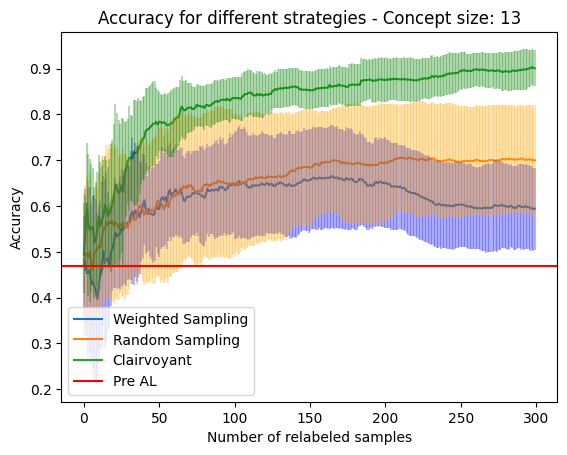

In [161]:
# create a new figure and axis object
fig, ax = plt.subplots()


# plot the accuracy values for each model as a line
ax.plot(range(len(mean_ws_accuracy)), mean_ws_accuracy, label='Weighted Sampling')
ax.plot(range(len(mean_rs_accuracy)), mean_rs_accuracy, label='Random Sampling')
ax.plot(range(len(mean_cl_accuracy)), mean_cl_accuracy, label='Clairvoyant')
ax.errorbar(range(len(mean_ws_accuracy)), mean_ws_accuracy, yerr=std_ws_accuracy, fmt='none', c='blue', alpha=0.3)
ax.errorbar(range(len(mean_rs_accuracy)), mean_rs_accuracy, yerr=std_rs_accuracy, fmt='none', c='orange', alpha=0.3)
ax.errorbar(range(len(mean_cl_accuracy)), mean_cl_accuracy, yerr=std_cl_accuracy, fmt='none', c='green', alpha=0.3)
plt.axhline(y=mean_pre_AL_accuracy, color='r', linestyle='-', label='Pre AL')

# add a legend to the plot
ax.legend()

# set the x-axis label
ax.set_xlabel('Number of relabeled samples')

# set the y-axis label
ax.set_ylabel('Accuracy')

# set the title of the plot
ax.set_title('Accuracy for different strategies - Concept size: ' + str(metadata[runs_dirs[0]]['last_concept_size']))

# display the plot

plt.show()

### Plot Selected Samples

In [162]:
pd.set_option('display.max_rows', None)

In [163]:
unmatched_samples = deepcopy(ws_selected_samples)

In [164]:
for (run, concept_list) in concept_list_dict.items():
    for concept in concept_list:
        unmatched_samples[run] = pd.merge(unmatched_samples[run], concept, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [165]:
# useful to know how many samples have been relabeled with a different label
# from the original one when applying change to the select samples methods
len(unmatched_samples)

10

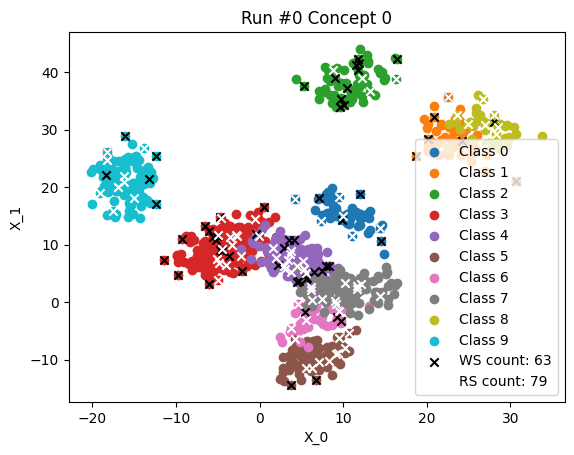

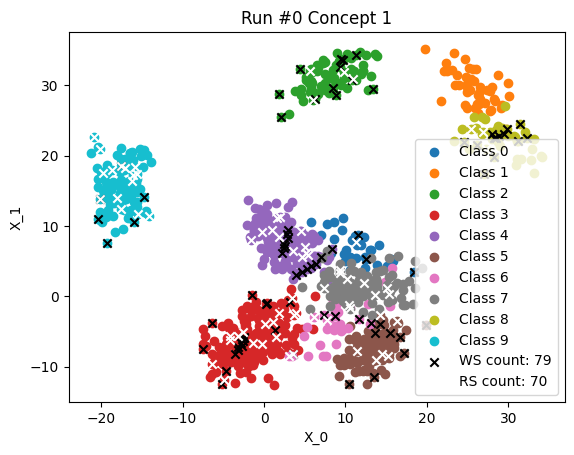

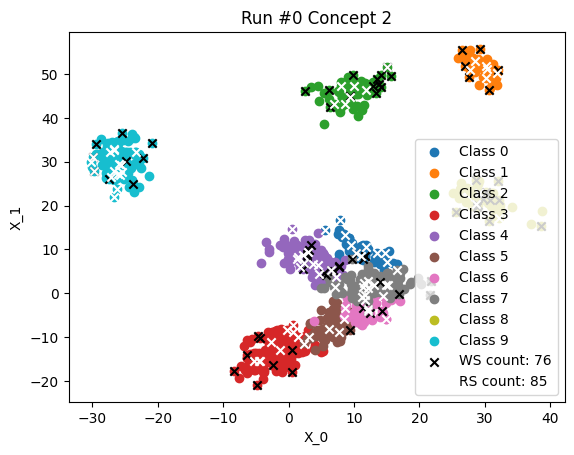

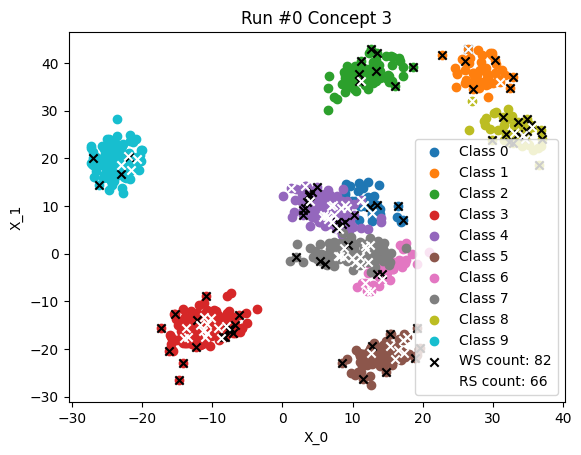

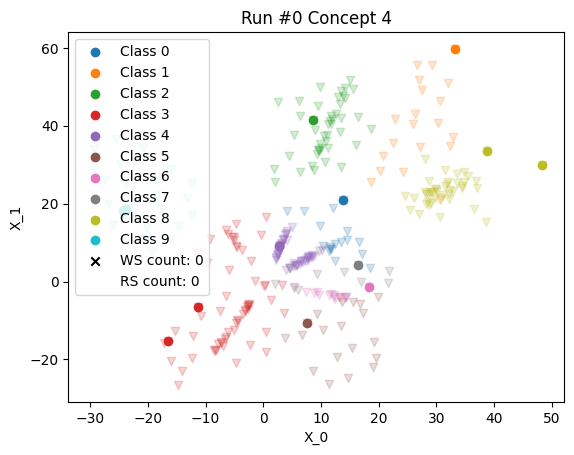

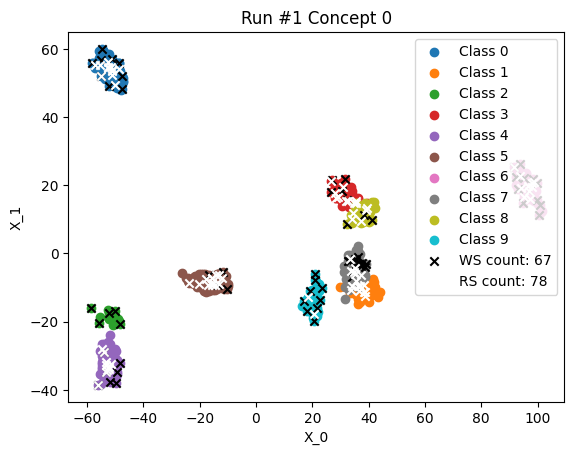

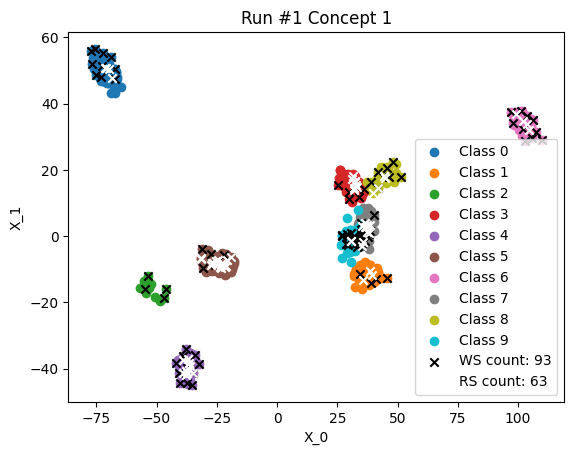

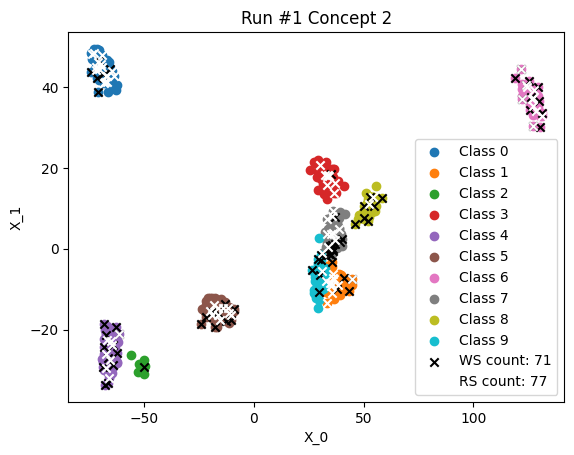

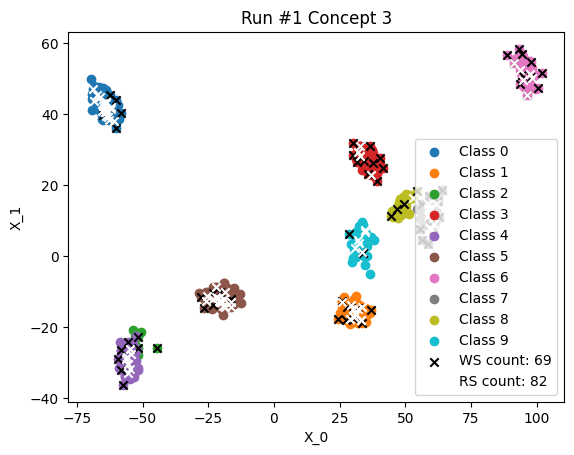

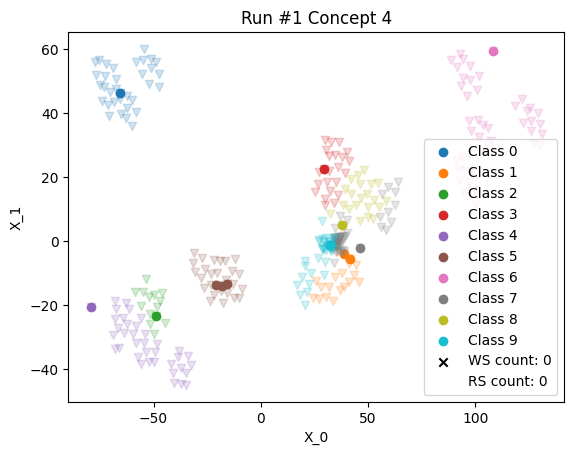

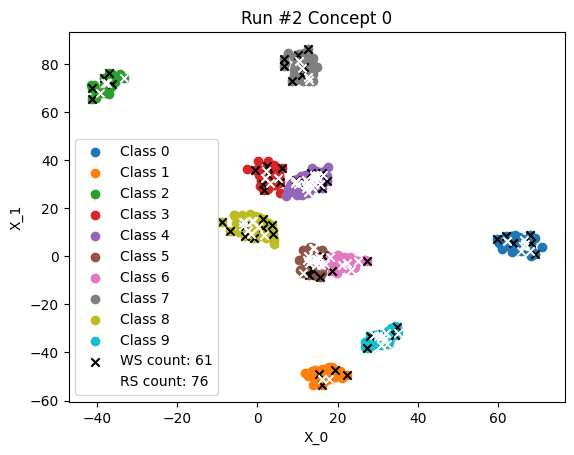

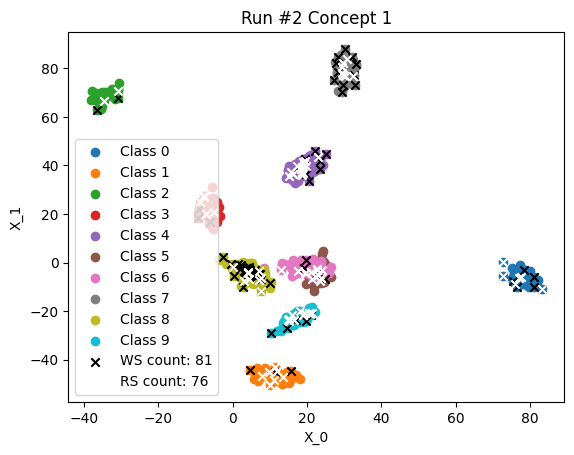

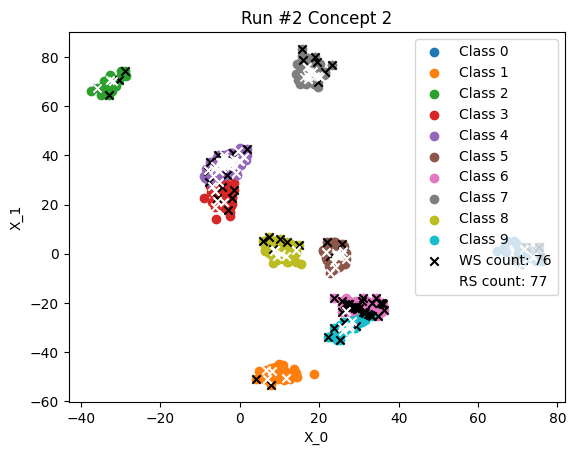

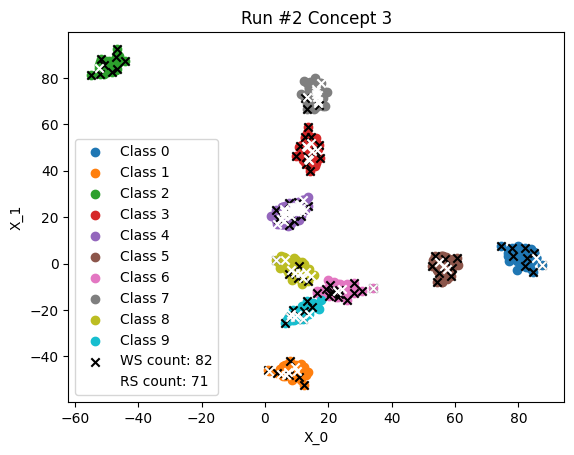

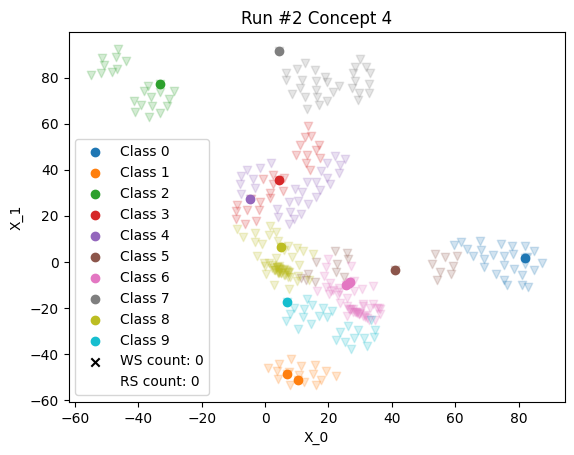

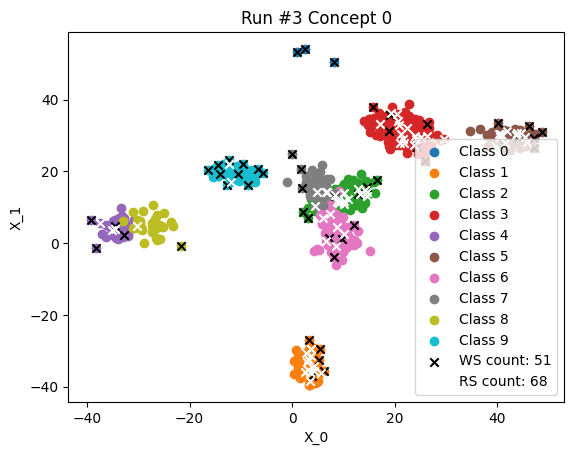

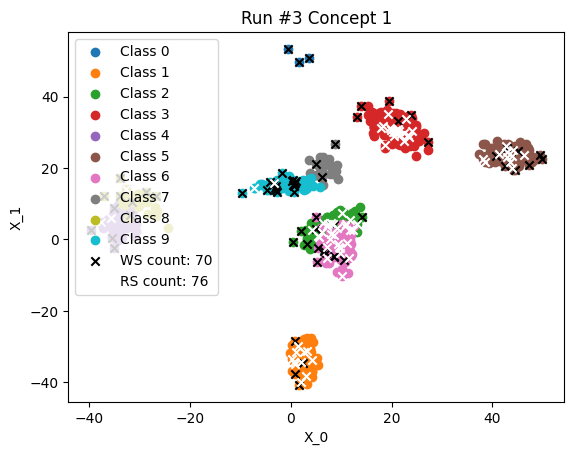

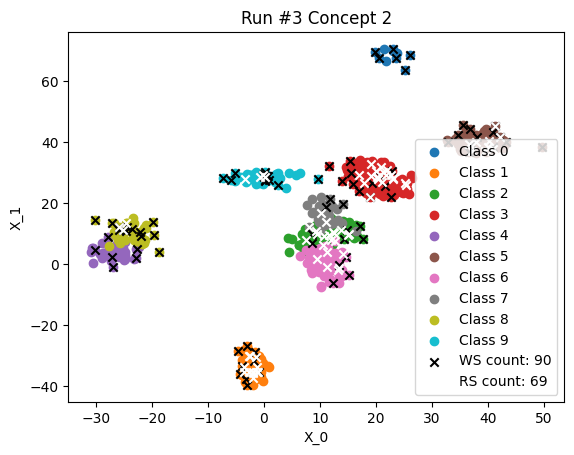

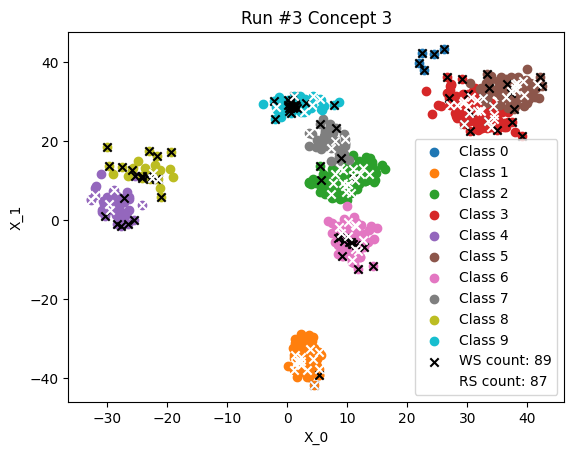

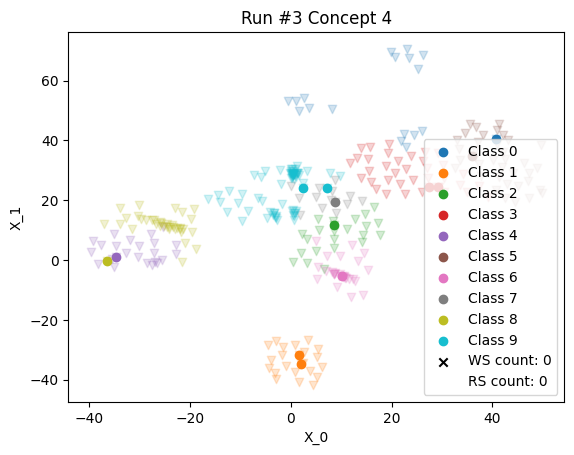

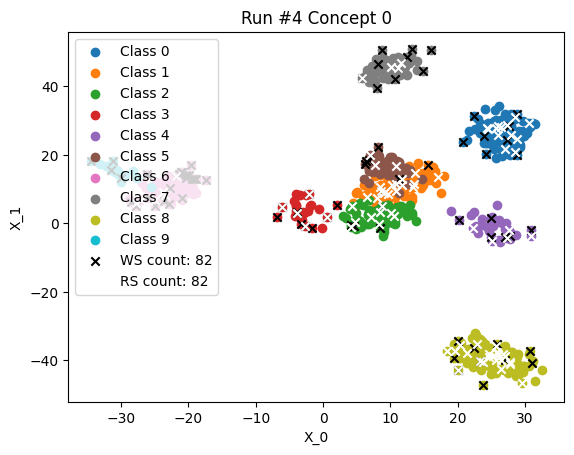

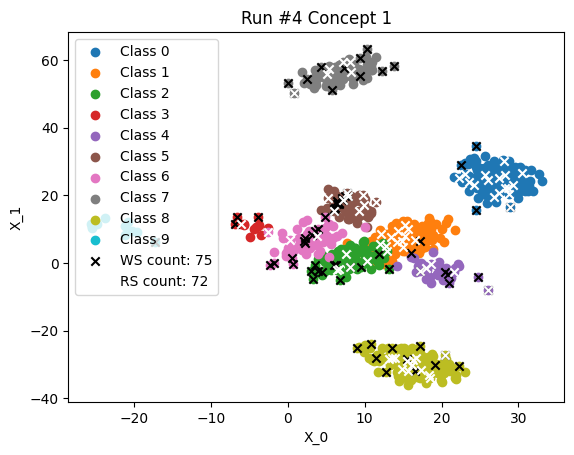

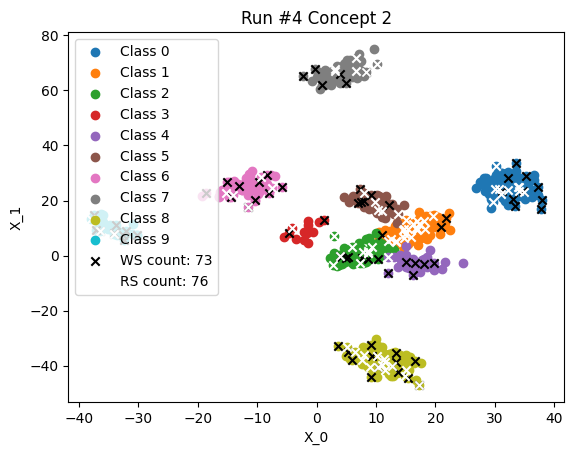

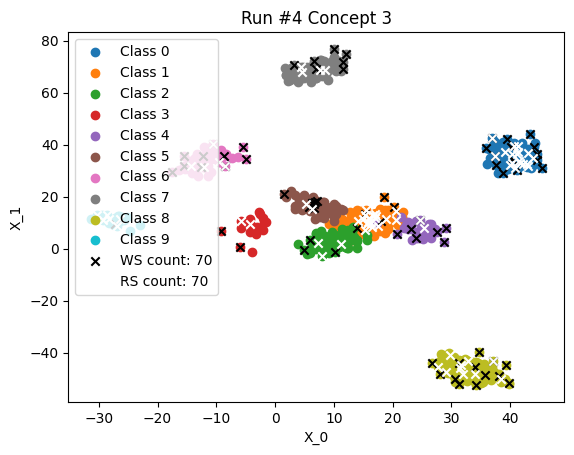

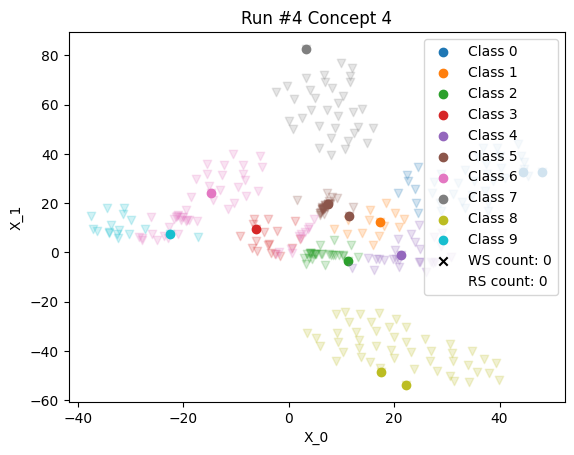

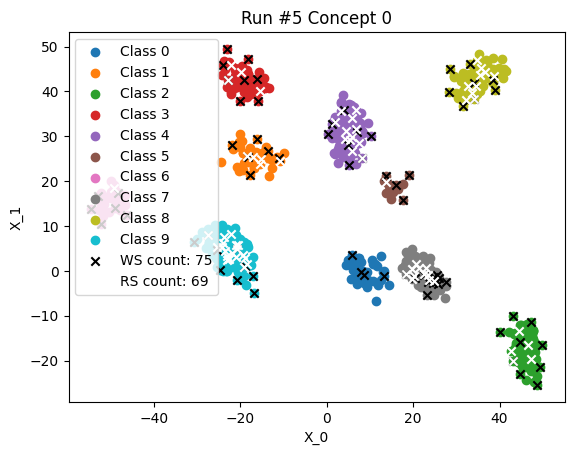

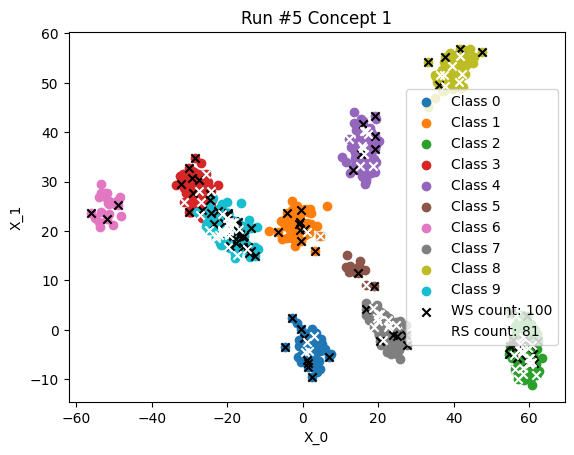

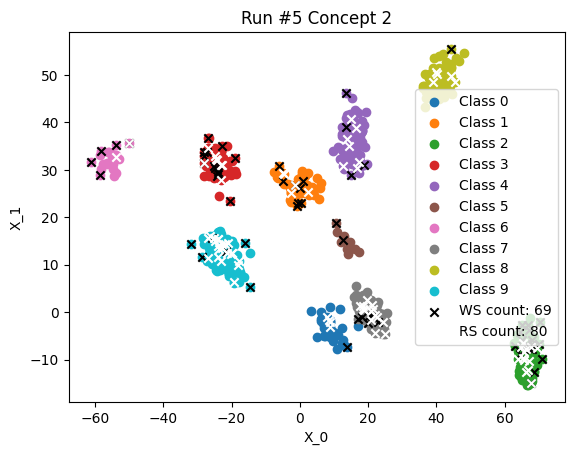

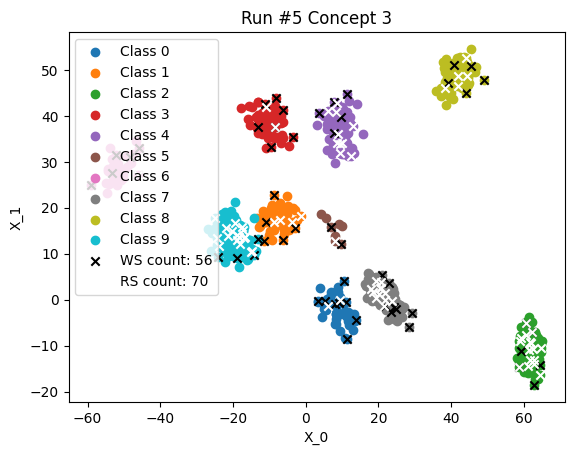

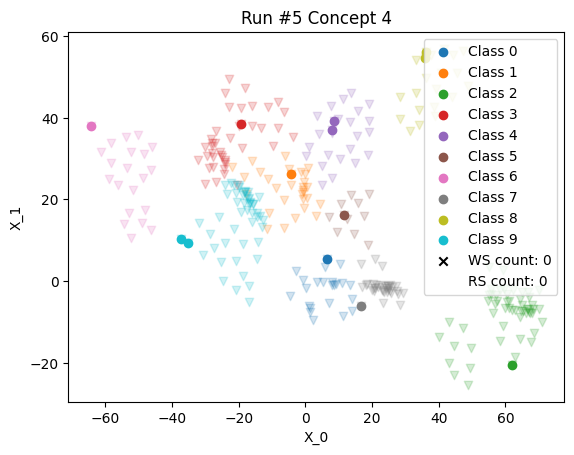

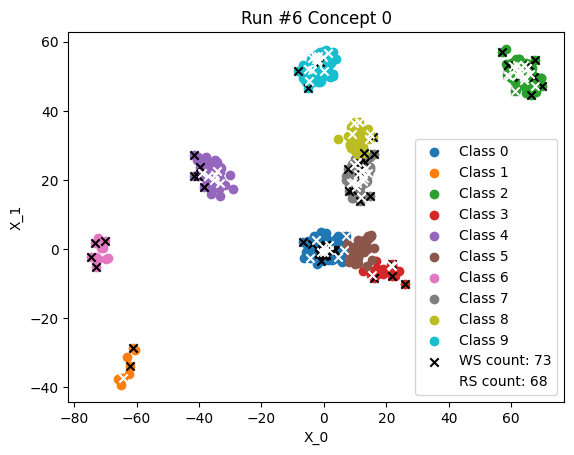

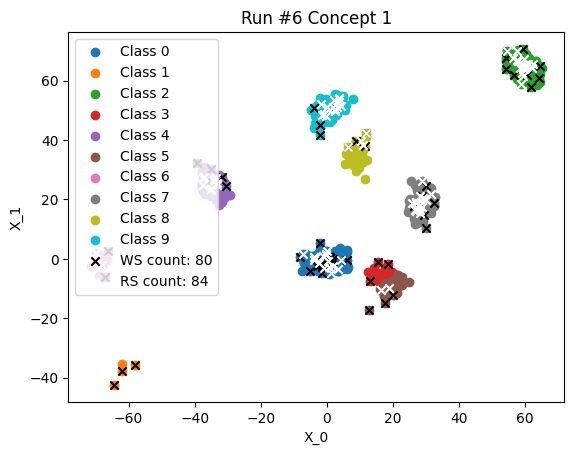

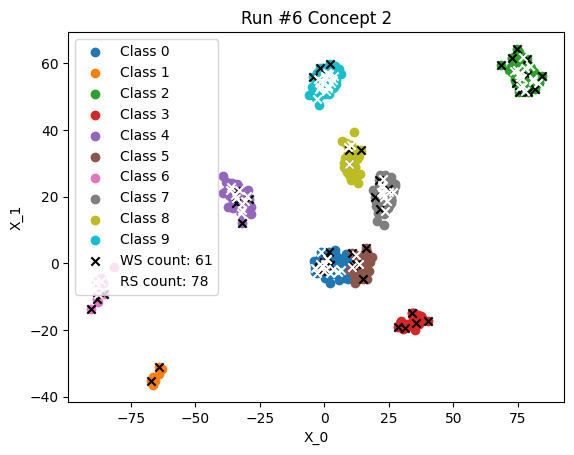

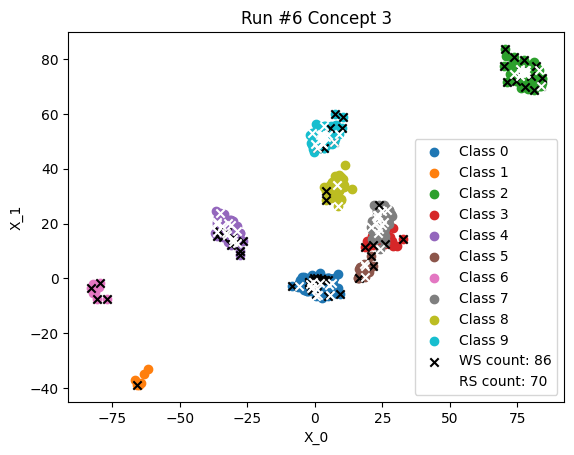

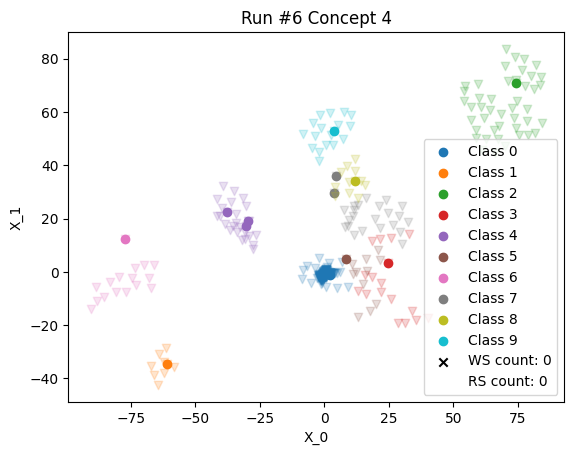

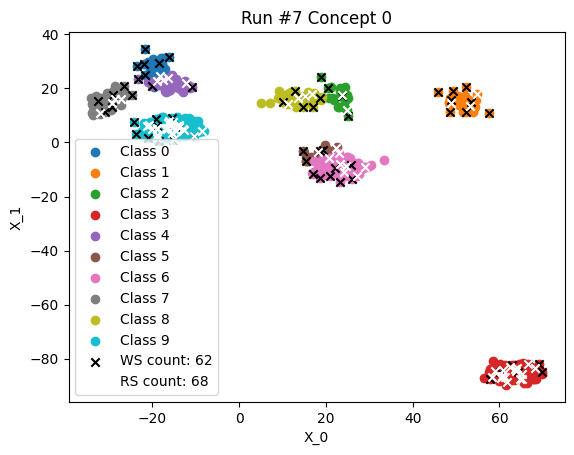

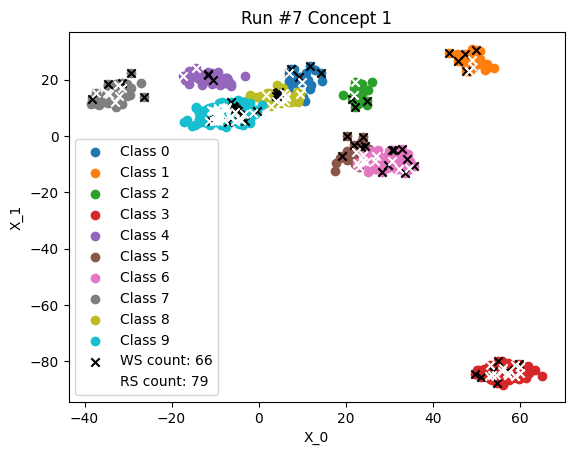

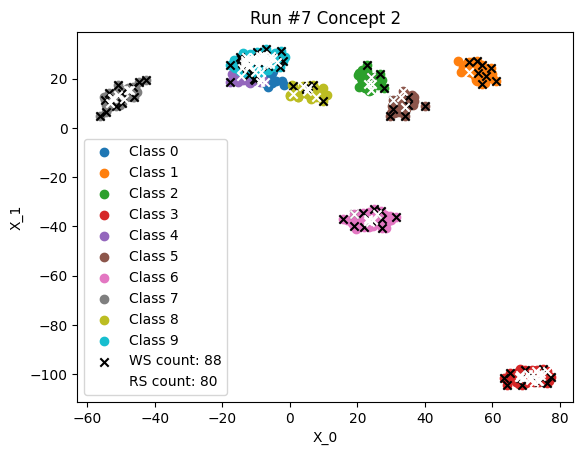

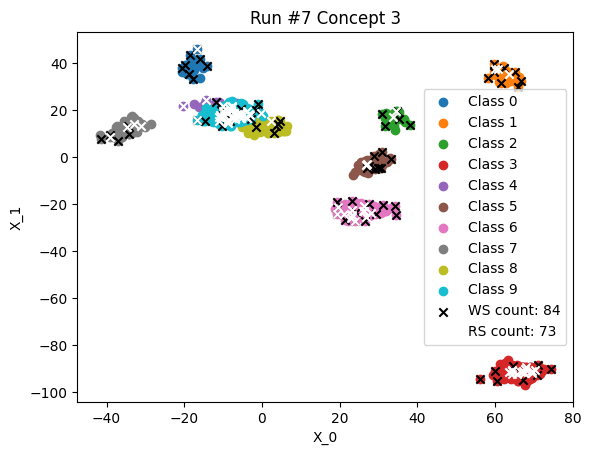

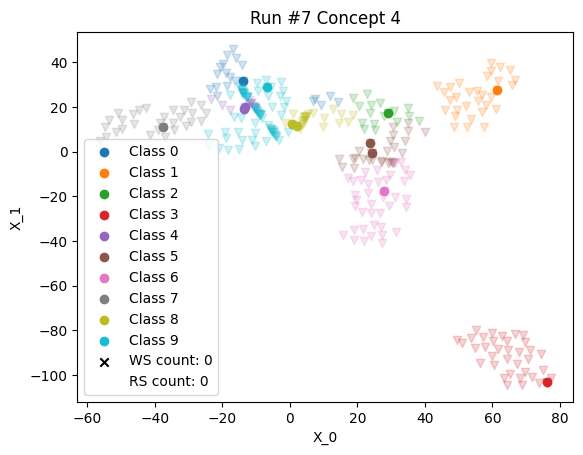

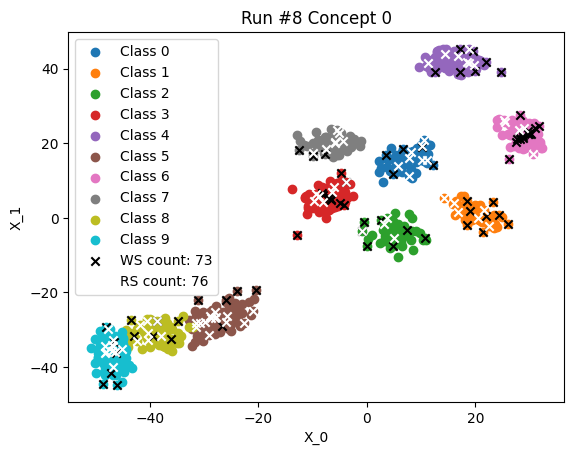

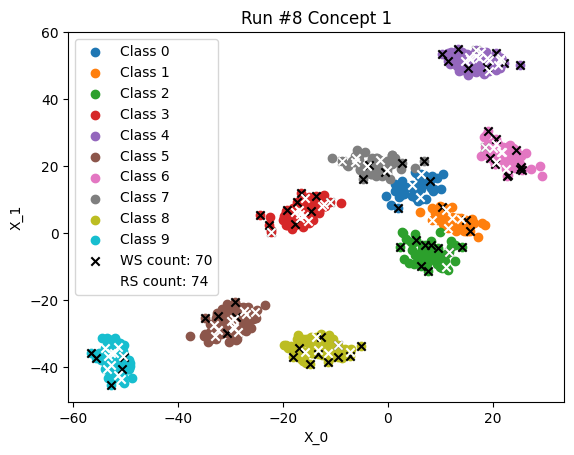

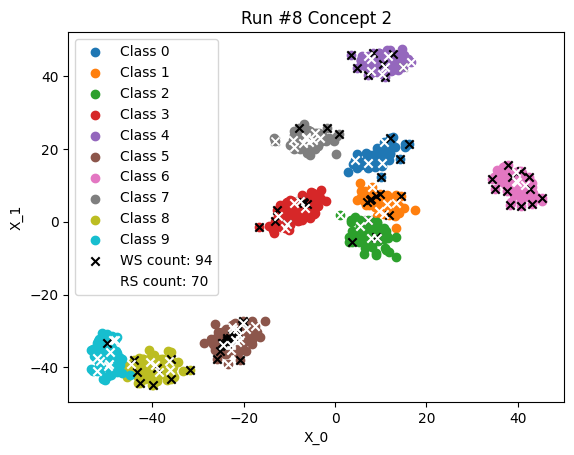

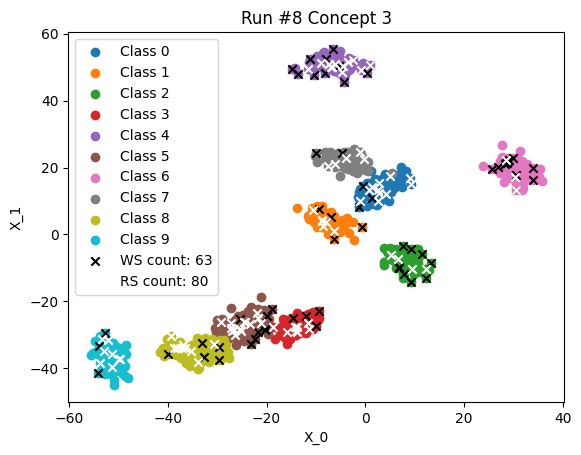

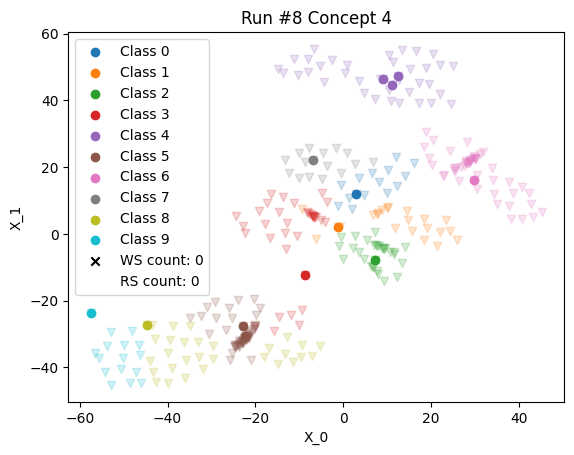

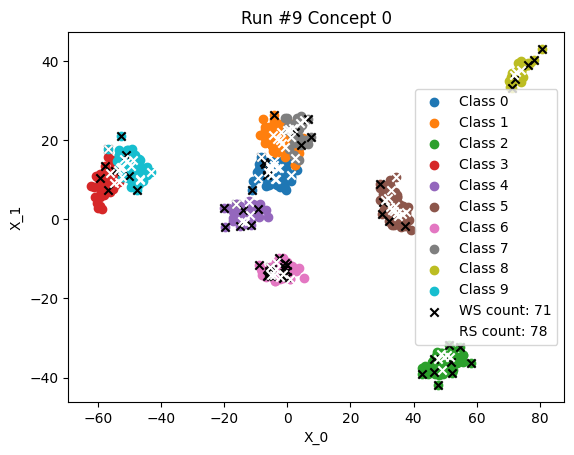

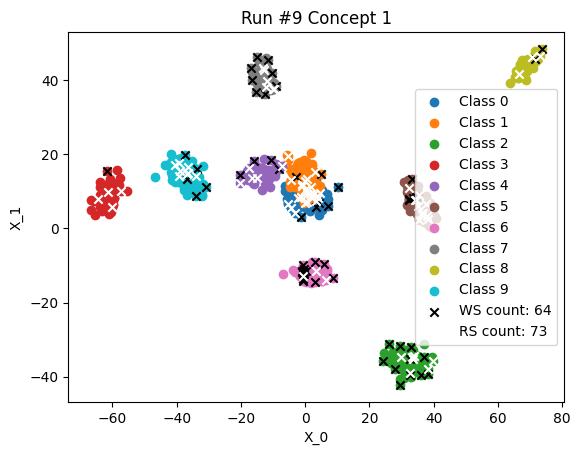

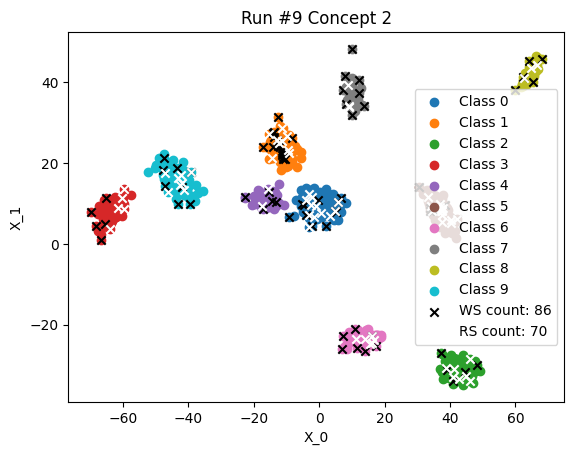

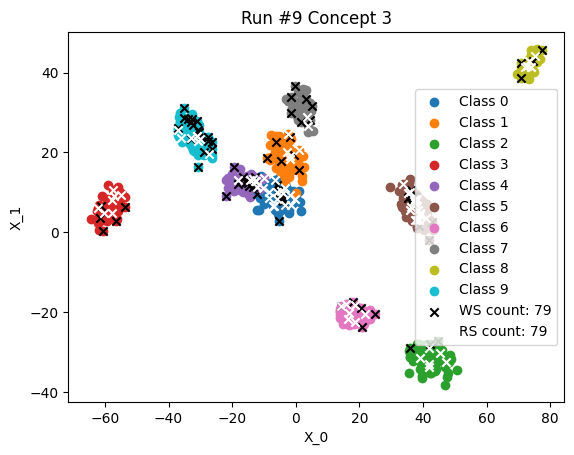

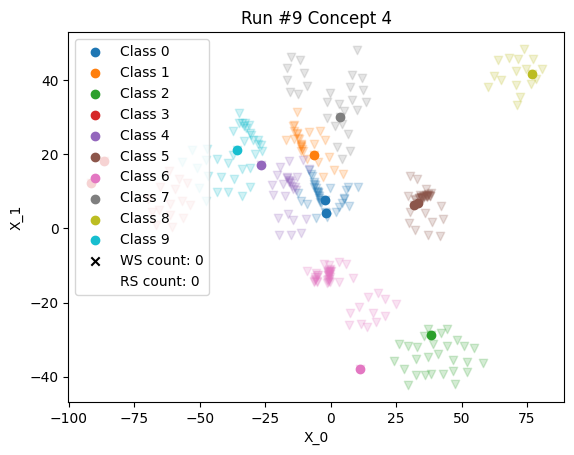

In [166]:
for (run, concept_list) in concept_list_dict.items():
    for index,concept in enumerate(concept_list):
        classes_groups = concept.groupby('y_0')

        selected_samples_ws = pd.merge(concept, ws_selected_samples[run])
        selected_samples_rs = pd.merge(concept, rs_selected_samples[run])

        fig, ax = plt.subplots()
        for i, (label, group) in enumerate(classes_groups):
            ax.scatter(group['X_0'], group['X_1'],
                    label='Class ' + str(int(label)), color=color_list[int(label)])

            if index == len(concept_list) - 1:
                class_samples = ws_selected_samples[run].loc[ws_selected_samples[run]['y_0'] == label]
                selected_samples = pd.concat([group, class_samples], axis=0)
                ax.scatter(selected_samples['X_0'], selected_samples['X_1'], color=color_list[int(label)], alpha=0.2, marker='v')

        plt.scatter(selected_samples_ws['X_0'], selected_samples_ws['X_1'], c='black', marker='x', label='WS count: ' + str(selected_samples_ws.value_counts().count()))
        plt.scatter(selected_samples_rs['X_0'], selected_samples_rs['X_1'], c='white', marker='x', label='RS count: ' + str(selected_samples_rs.value_counts().count()))
        plt.xlabel('X_0')
        plt.ylabel('X_1')
        ax.legend()
        plt.title('Run #' + str(run) + ' Concept ' + str(index))
        plt.show()

In [167]:
metadata['0']['means_per_concept']

{'0': {'0': [10.040337952606459, 14.785368727893335],
  '1': [22.807359675618034, 28.64661275965105],
  '2': [10.63654254128855, 37.9882623666317],
  '3': [-3.8565247237716616, 9.714799118800796],
  '4': [4.2663104349820085, 7.063219995442015],
  '5': [6.321636811607073, -9.783656571790203],
  '6': [6.428983237759424, -2.598903759479362],
  '7': [10.16742313121675, 2.161309668169622],
  '8': [27.29402203761457, 29.860990414691432],
  '9': [-16.477636163976978, 21.288434681835913]},
 '1': {'0': [10.923586181214592, 7.083898688252752],
  '1': [26.115624129823395, 29.89968921542738],
  '2': [8.223143742035921, 31.464096140736263],
  '3': [-0.9301237052774631, -5.929499122195162],
  '4': [2.6635372171260627, 7.794714808422858],
  '5': [13.710870280340064, -7.346705721929348],
  '6': [9.218809904911598, -2.736709415669925],
  '7': [12.598634211429957, 1.6476595921821229],
  '8': [28.98222230050988, 22.71164394530692],
  '9': [-17.521028349304565, 15.628610142762017]},
 '2': {'0': [11.080498

In [168]:
metadata['2']['means']

KeyError: 'means'

In [ ]:
metadata_0 = np.array(metadata['0']['means'])
metadata_2 = np.array(metadata['2']['means'])

np.subtract(metadata_0, metadata_2)

In [ ]:
metadata['0']['covs']

In [ ]:
metadata['2']['means']

In [ ]:
metadata['4']['means']